In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
import time
from scipy import ndimage
import os

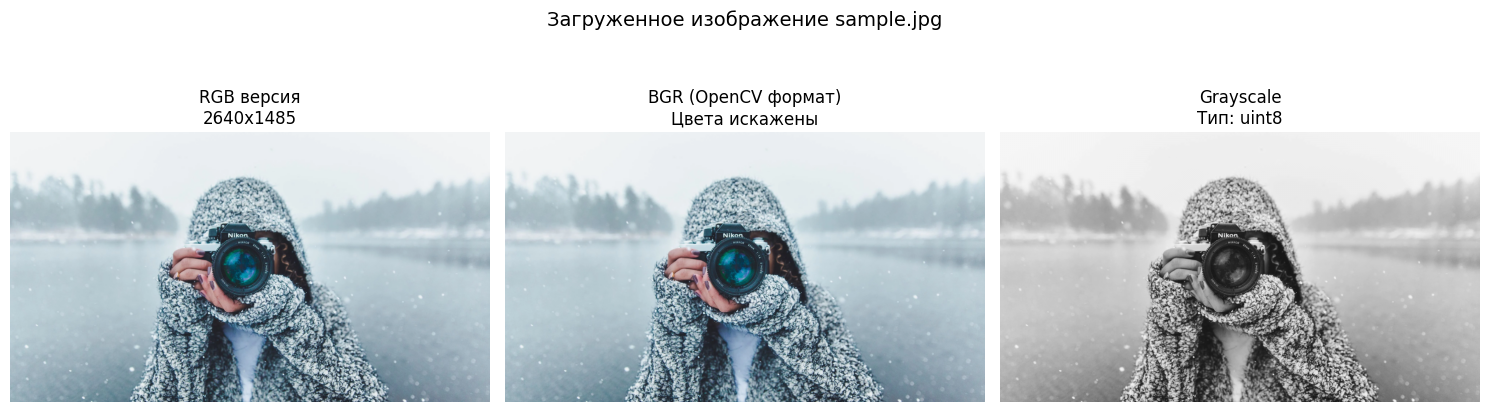

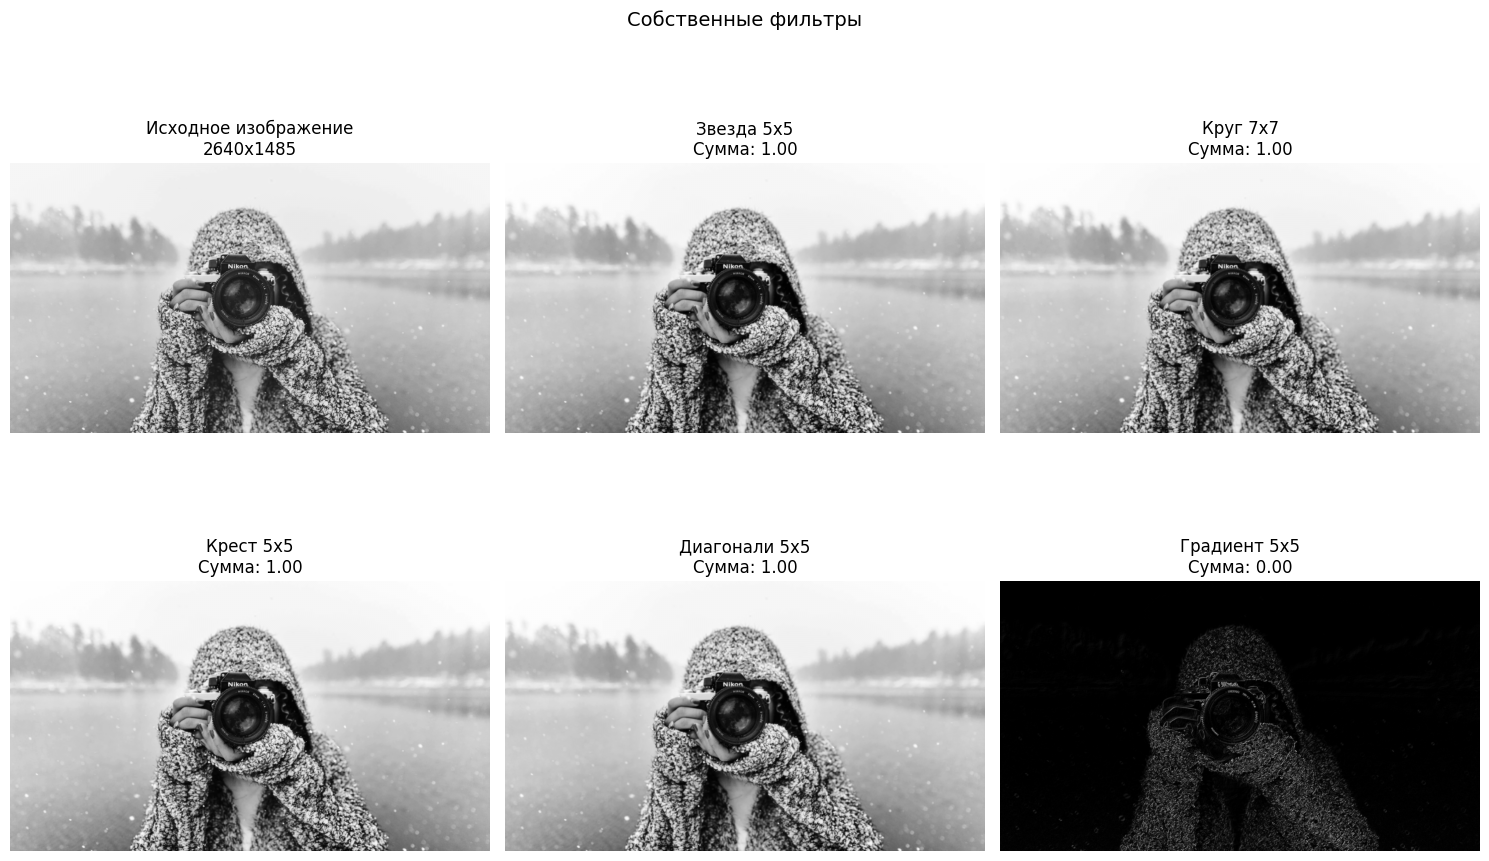


🔍 Визуализация ядер собственных фильтров:


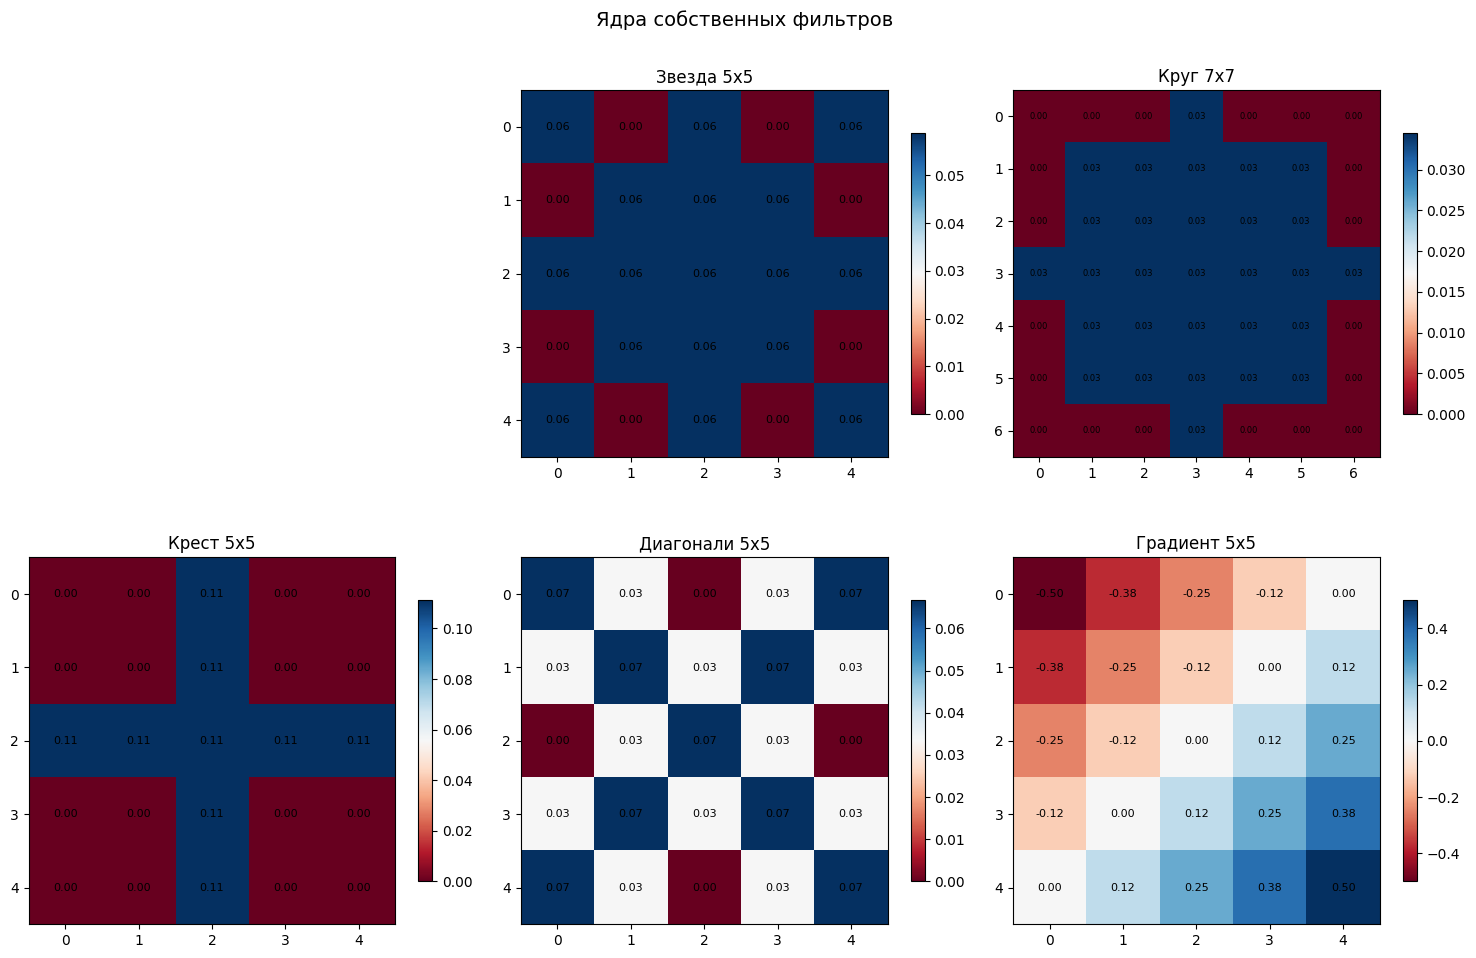

In [17]:
# Загружаем изображение sample.jpg
img = cv2.imread('sample.jpg')

# Проверяем, что изображение загружено
if img is None:
    raise FileNotFoundError("Файл 'sample.jpg' не найден. Убедитесь, что файл существует в текущей директории.")

# Конвертируем в RGB для matplotlib
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Конвертируем в grayscale для фильтров
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Показываем загруженное изображение
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_rgb)
axes[0].set_title(f'RGB версия\n{img.shape[1]}x{img.shape[0]}')
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
axes[1].set_title('BGR (OpenCV формат)\nЦвета искажены')
axes[1].axis('off')

axes[2].imshow(img_gray, cmap='gray')
axes[2].set_title(f'Grayscale\nТип: {img_gray.dtype}')
axes[2].axis('off')

plt.suptitle('Загруженное изображение sample.jpg', fontsize=14)
plt.tight_layout()
plt.show()

# ===============================
# Вспомогательные функции
# ===============================

def create_gaussian_kernel(size, sigma):
    """Создание гауссова ядра"""
    kernel = np.zeros((size, size))
    center = size // 2

    for i in range(size):
        for j in range(size):
            x, y = i - center, j - center
            kernel[i, j] = np.exp(-(x*x + y*y) / (2 * sigma*sigma))

    # Нормализуем (сумма должна быть 1)
    kernel = kernel / kernel.sum()
    return kernel

def separable_gaussian_blur(image, sigma, ksize):
    """
    Реализация сепарабельного гауссова размытия
    Вместо одной свёртки NxN делаем две свёртки 1xN и Nx1
    """
    # Создаём 1D гауссово ядро
    center = ksize // 2
    kernel_1d = np.zeros(ksize)

    for i in range(ksize):
        x = i - center
        kernel_1d[i] = np.exp(-(x*x) / (2 * sigma*sigma))

    # Нормализуем
    kernel_1d = kernel_1d / kernel_1d.sum()

    # Применяем горизонтальную свёртку
    horizontal_kernel = kernel_1d.reshape(1, -1)
    temp = cv2.filter2D(image, -1, horizontal_kernel)

    # Применяем вертикальную свёртку
    vertical_kernel = kernel_1d.reshape(-1, 1)
    result = cv2.filter2D(temp, -1, vertical_kernel)

    return result, kernel_1d

# ===============================
# Часть 1: Создание собственного фильтра
# ===============================

def create_custom_filter(filter_type='star', size=5):
    """
    Создание собственных фильтров разного типа

    Args:
        filter_type: тип фильтра ('star', 'circle', 'cross', 'diagonal')
        size: размер ядра (нечетное число)

    Returns:
        Ядро фильтра
    """
    if size % 2 == 0:
        size += 1  # Делаем размер нечетным

    kernel = np.zeros((size, size))
    center = size // 2

    if filter_type == 'star':
        # Звездообразный фильтр
        for i in range(size):
            for j in range(size):
                if i == center or j == center or i == j or i + j == size - 1:
                    kernel[i, j] = 1
        kernel = kernel / kernel.sum()

    elif filter_type == 'circle':
        # Круговой фильтр
        radius = size // 2
        for i in range(size):
            for j in range(size):
                dist = np.sqrt((i - center)**2 + (j - center)**2)
                if dist <= radius:
                    kernel[i, j] = 1
        kernel = kernel / kernel.sum()

    elif filter_type == 'cross':
        # Крестообразный фильтр
        for i in range(size):
            for j in range(size):
                if i == center or j == center:
                    kernel[i, j] = 1
        kernel = kernel / kernel.sum()

    elif filter_type == 'diagonal':
        # Диагональный фильтр
        for i in range(size):
            for j in range(size):
                if i == j:
                    kernel[i, j] = 2
                elif i + j == size - 1:
                    kernel[i, j] = 2
                elif abs(i - j) == 1 or abs(i + j - (size - 1)) == 1:
                    kernel[i, j] = 1
        kernel = kernel / kernel.sum()

    elif filter_type == 'gradient':
        # Градиентный фильтр
        for i in range(size):
            for j in range(size):
                kernel[i, j] = (i + j) / (2 * (size - 1))
        kernel = kernel - kernel.mean()

    return kernel

# Тестируем собственные фильтры
custom_filters = {
    'Звезда 5x5': create_custom_filter('star', 5),
    'Круг 7x7': create_custom_filter('circle', 7),
    'Крест 5x5': create_custom_filter('cross', 5),
    'Диагонали 5x5': create_custom_filter('diagonal', 5),
    'Градиент 5x5': create_custom_filter('gradient', 5)
}

# Применяем фильтры к изображению
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title(f'Исходное изображение\n{img_gray.shape[1]}x{img_gray.shape[0]}')
axes[0].axis('off')

for i, (name, kernel) in enumerate(custom_filters.items(), 1):
    if i < len(axes):
        # Применяем фильтр
        if 'Градиент' in name:
            # Для градиентного фильтра нужна специальная обработка
            filtered = cv2.filter2D(img_gray.astype(np.float32), -1, kernel)
            filtered = np.abs(filtered)
            filtered = (filtered / filtered.max() * 255).astype(np.uint8)
        else:
            filtered = cv2.filter2D(img_gray, -1, kernel)

        axes[i].imshow(filtered, cmap='gray')
        axes[i].set_title(f'{name}\nСумма: {kernel.sum():.2f}')
        axes[i].axis('off')

plt.suptitle('Собственные фильтры', fontsize=14)
plt.tight_layout()
plt.show()

# Визуализируем сами ядра
print("\n🔍 Визуализация ядер собственных фильтров:")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

axes[0].axis('off')  # Первую ось оставляем пустой для выравнивания

for i, (name, kernel) in enumerate(custom_filters.items()):
    if i+1 < len(axes):
        im = axes[i+1].imshow(kernel, cmap='RdBu', interpolation='nearest')
        axes[i+1].set_title(f'{name}')
        plt.colorbar(im, ax=axes[i+1], shrink=0.6)

        # Добавляем значения в ячейки
        for y in range(kernel.shape[0]):
            for x in range(kernel.shape[1]):
                axes[i+1].text(x, y, f'{kernel[y,x]:.2f}',
                             ha='center', va='center', fontsize=8 if kernel.shape[0] <= 5 else 6)

plt.suptitle('Ядра собственных фильтров', fontsize=14)
plt.tight_layout()
plt.show()



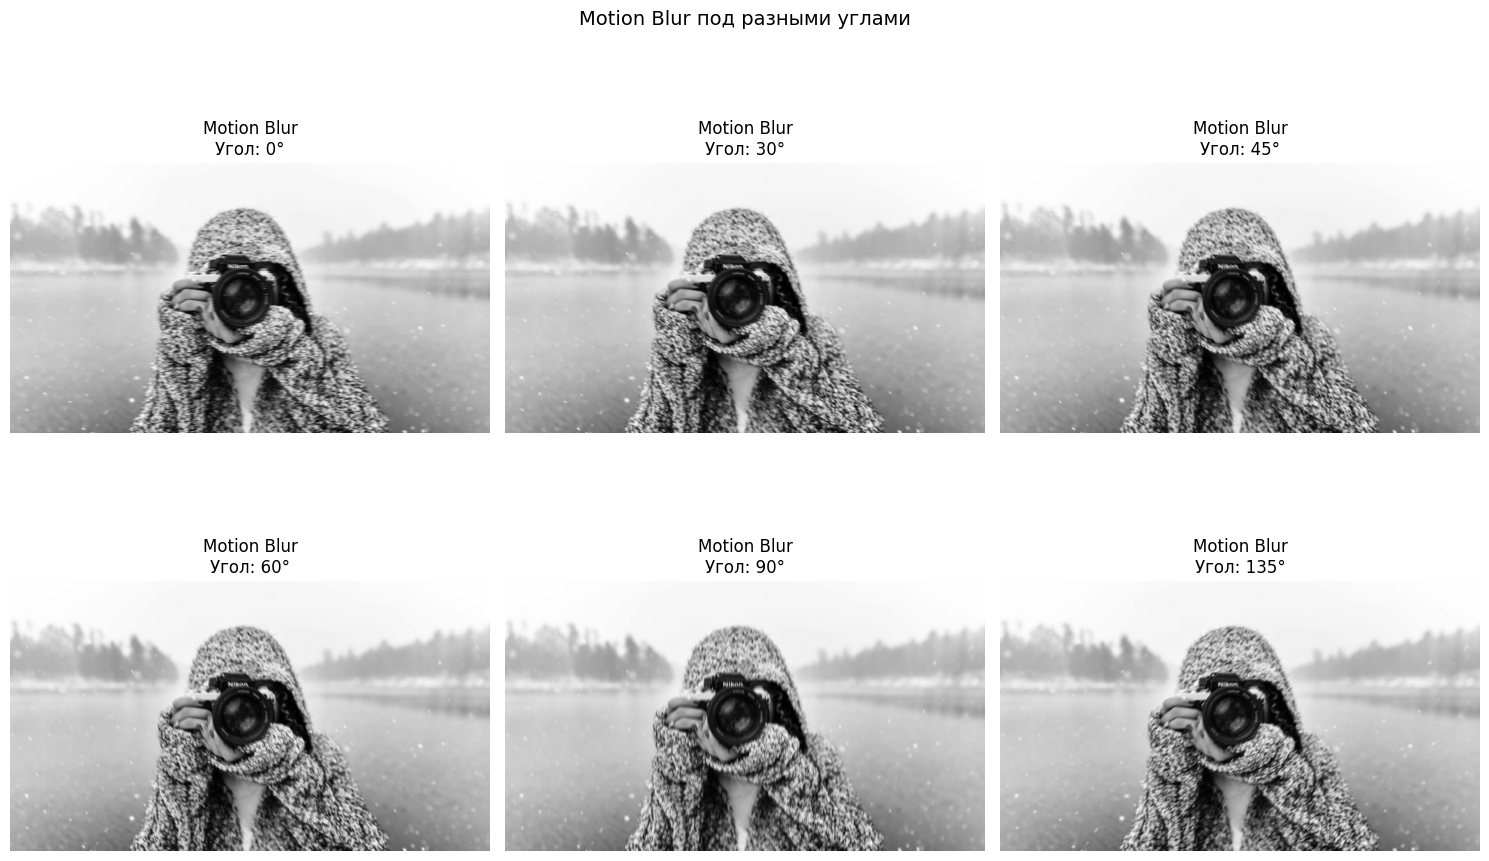

In [18]:
# ===============================
# Часть 2: Motion Blur под произвольным углом
# ===============================

def create_motion_blur_kernel(length, angle=0, kernel_size=15):
    """Создание ядра motion blur под произвольным углом"""
    kernel = np.zeros((kernel_size, kernel_size))
    center = kernel_size // 2

    angle_rad = np.deg2rad(angle)

    dx = length * np.cos(angle_rad) / 2
    dy = length * np.sin(angle_rad) / 2

    x_start = center - dx
    y_start = center - dy
    x_end = center + dx
    y_end = center + dy

    steps = int(max(abs(x_end - x_start), abs(y_end - y_start)))
    if steps == 0:
        kernel[int(center), int(center)] = 1
        return kernel

    for i in range(steps + 1):
        t = i / steps
        x = x_start + (x_end - x_start) * t
        y = y_start + (y_end - y_start) * t

        xi = int(round(x))
        yi = int(round(y))

        if 0 <= xi < kernel_size and 0 <= yi < kernel_size:
            kernel[yi, xi] = 1

    if kernel.sum() > 0:
        kernel = kernel / kernel.sum()

    return kernel

# Тестируем motion blur
angles = [0, 30, 45, 60, 90, 135]
length = 15
kernel_size = 21

n_angles = len(angles)
n_cols = 3
n_rows = (n_angles + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

axes = axes.flatten()

for i, angle in enumerate(angles):
    motion_kernel = create_motion_blur_kernel(length, angle, kernel_size)
    blurred = cv2.filter2D(img_gray, -1, motion_kernel)

    axes[i].imshow(blurred, cmap='gray')
    axes[i].set_title(f'Motion Blur\nУгол: {angle}°')
    axes[i].axis('off')

# Скрываем лишние оси
for i in range(n_angles, len(axes)):
    axes[i].axis('off')

plt.suptitle('Motion Blur под разными углами', fontsize=14)
plt.tight_layout()
plt.show()

🚀 Сравнение производительности методов размытия...

Метод                Время (сек) 
-----------------------------------
Box filter           0.0557      
Gaussian blur        0.0058      
Median blur          0.0035      
Bilateral filter     0.0720      


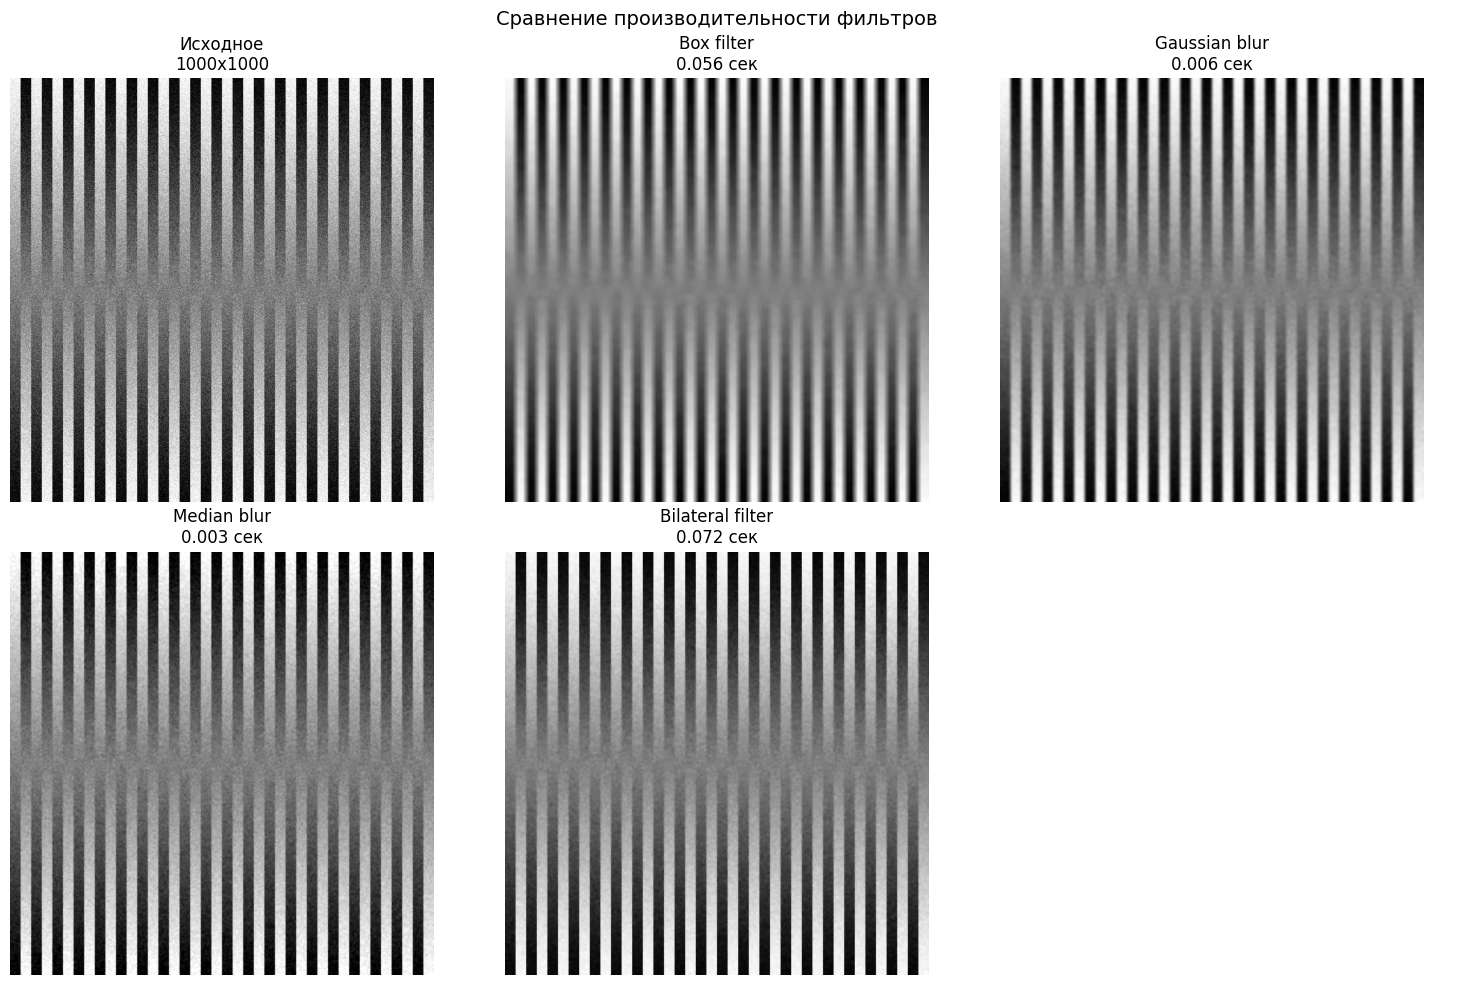

In [22]:
# ===============================
# Часть 3: Сравнение производительности методов размытия
# ===============================

def create_test_image(size=1000):
    """Создание тестового изображения"""
    img = np.zeros((size, size), dtype=np.uint8)

    for i in range(size):
        img[i, :] = (i * 255) // size

    for i in range(0, size, 50):
        img[:, i:i+25] = 255 - img[:, i:i+25]

    noise = np.random.normal(0, 30, (size, size))
    img = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    return img

print("🚀 Сравнение производительности методов размытия...")
test_img = create_test_image(1000)  # Уменьшаем размер для скорости

methods = []
times = []
results = []

# 1. Box фильтр
kernel_size = 15
box_kernel = np.ones((kernel_size, kernel_size)) / (kernel_size * kernel_size)
start = time.time()
result_box = cv2.filter2D(test_img, -1, box_kernel)
time_box = time.time() - start
methods.append('Box filter')
times.append(time_box)
results.append(result_box)

# 2. Гауссово размытие (встроенное)
sigma = 3.0
start = time.time()
result_gauss = cv2.GaussianBlur(test_img, (kernel_size, kernel_size), sigma)
time_gauss = time.time() - start
methods.append('Gaussian blur')
times.append(time_gauss)
results.append(result_gauss)

# 3. Median blur
start = time.time()
result_median = cv2.medianBlur(test_img, 5)
time_median = time.time() - start
methods.append('Median blur')
times.append(time_median)
results.append(result_median)

# 4. Bilateral filter
start = time.time()
result_bilateral = cv2.bilateralFilter(test_img, 9, 75, 75)
time_bilateral = time.time() - start
methods.append('Bilateral filter')
times.append(time_bilateral)
results.append(result_bilateral)

# Выводим результаты
print(f"\n{'Метод':<20} {'Время (сек)':<12}")
print("-" * 35)
for method, t in zip(methods, times):
    print(f"{method:<20} {t:<12.4f}")

# Визуализация
n_methods = len(methods) + 1
n_cols = 3
n_rows = (n_methods + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

axes = axes.flatten()

# Исходное изображение
axes[0].imshow(test_img, cmap='gray')
axes[0].set_title('Исходное\n1000x1000')
axes[0].axis('off')

# Результаты фильтрации
for i in range(len(methods)):
    axes[i+1].imshow(results[i], cmap='gray')
    axes[i+1].set_title(f'{methods[i]}\n{times[i]:.3f} сек')
    axes[i+1].axis('off')

# Скрываем лишние оси
for i in range(n_methods, len(axes)):
    axes[i].axis('off')

plt.suptitle('Сравнение производительности фильтров', fontsize=14)
plt.tight_layout()
plt.show()

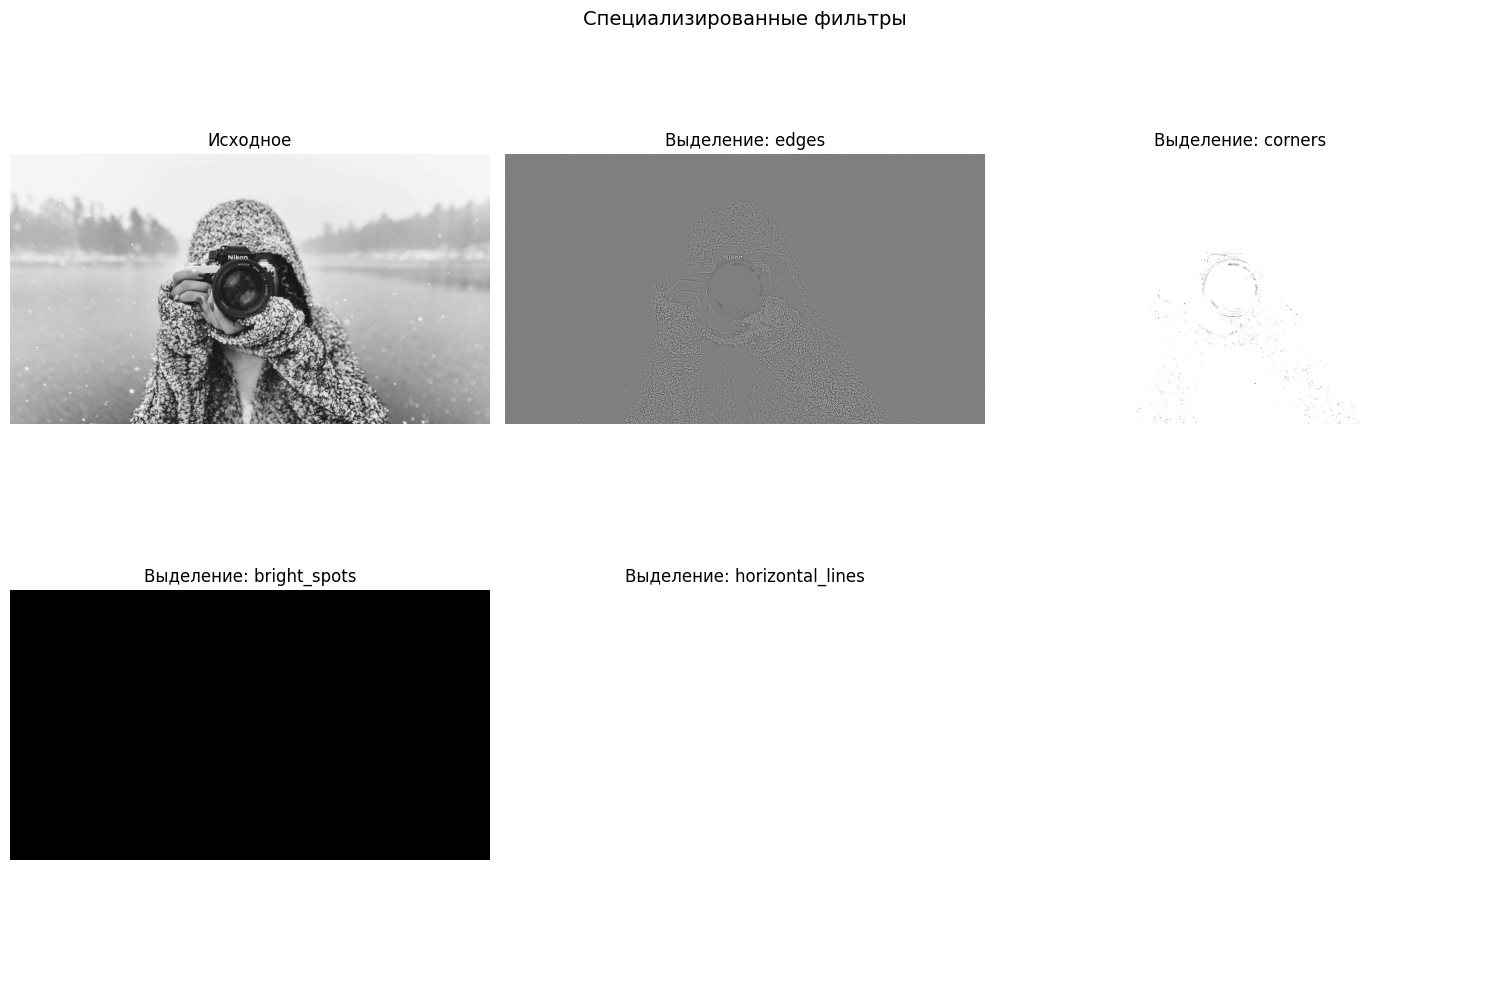

In [20]:
# ===============================
# Часть 4: Специализированные фильтры для выделения особенностей
# ===============================

def create_feature_enhancement_filter(feature_type='edges', size=5):
    """Создание фильтров для выделения особенностей"""
    if size % 2 == 0:
        size += 1

    kernel = np.zeros((size, size))
    center = size // 2

    if feature_type == 'edges':
        kernel = np.array([[-1, -1, -1],
                          [-1,  8, -1],
                          [-1, -1, -1]])

    elif feature_type == 'corners':
        for i in range(size):
            for j in range(size):
                if (i == 0 and j == 0) or (i == 0 and j == size-1) or \
                   (i == size-1 and j == 0) or (i == size-1 and j == size-1):
                    kernel[i, j] = 2
                elif i == center and j == center:
                    kernel[i, j] = -4

    elif feature_type == 'bright_spots':
        for i in range(size):
            for j in range(size):
                dist = np.sqrt((i - center)**2 + (j - center)**2)
                if dist <= 1:
                    kernel[i, j] = 8
                elif dist <= 2:
                    kernel[i, j] = -1

    elif feature_type == 'horizontal_lines':
        kernel[center, :] = 1
        if center > 0:
            kernel[center-1, :] = 1
            kernel[center+1, :] = 1
        kernel[center, center] = -(size - 1)

    return kernel

# Тестируем только 4 основных фильтра
feature_types = ['edges', 'corners', 'bright_spots', 'horizontal_lines']

n_features = len(feature_types) + 1
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

axes = axes.flatten()

# Исходное изображение
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title('Исходное')
axes[0].axis('off')

# Применяем фильтры
for i, feature_type in enumerate(feature_types, 1):
    if i < len(axes):
        feature_kernel = create_feature_enhancement_filter(feature_type, 7)
        filtered = cv2.filter2D(img_gray.astype(np.float32), -1, feature_kernel)
        filtered_display = np.clip(filtered + 128, 0, 255).astype(np.uint8)

        axes[i].imshow(filtered_display, cmap='gray')
        axes[i].set_title(f'Выделение: {feature_type}')
        axes[i].axis('off')

# Скрываем лишние оси
for i in range(n_features, len(axes)):
    axes[i].axis('off')

plt.suptitle('Специализированные фильтры', fontsize=14)
plt.tight_layout()
plt.show()
